<a href="https://colab.research.google.com/github/Bimal2002/spam_email_detection/blob/master/SpamEmailDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import nltk
from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize, sent_tokenize
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import re
from collections import Counter

nltk.download('punkt') # Download punkt sentence tokenizer data
nltk.download('stopwords') # Make sure stopwords are downloaded as well
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Load Dataset

In [3]:
data = pd.read_csv("combined_data.csv", encoding='ISO-8859-1')
print("Dataset shape:", data.shape)
data.head()




Dataset shape: (83448, 2)


,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


# Exploratory Data Analysis (EDA)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB
None
Missing values per column:
 label    0
text     0
dtype: int64
Number of duplicate rows: 0
Shape after removing duplicates: (83448, 2)


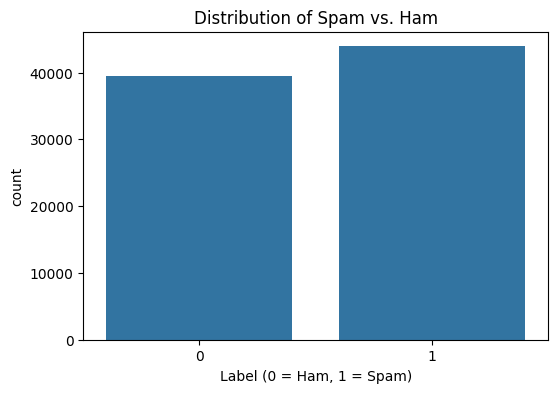

Average text length: 1671.4161034416643
Average word count: 285.5552559677883
Average sentence count: 7.250059917553447


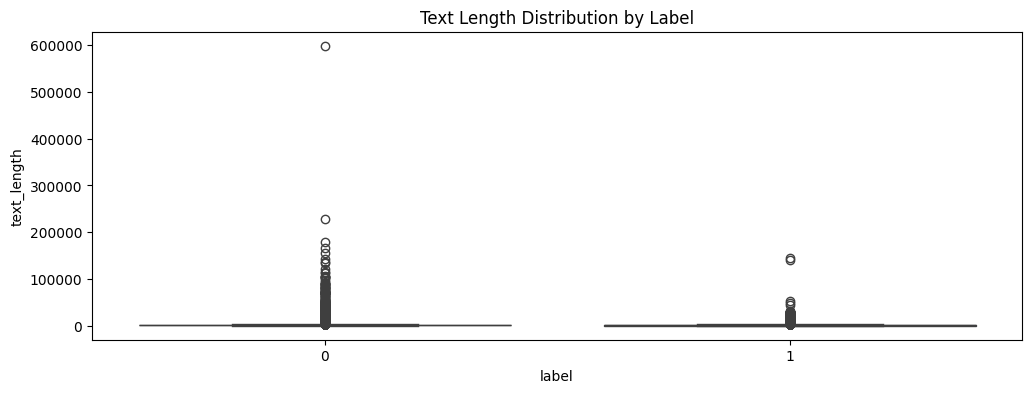

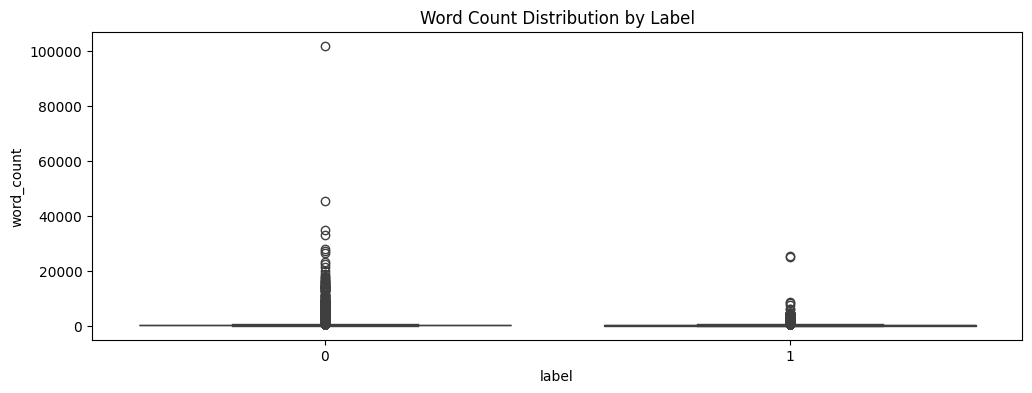

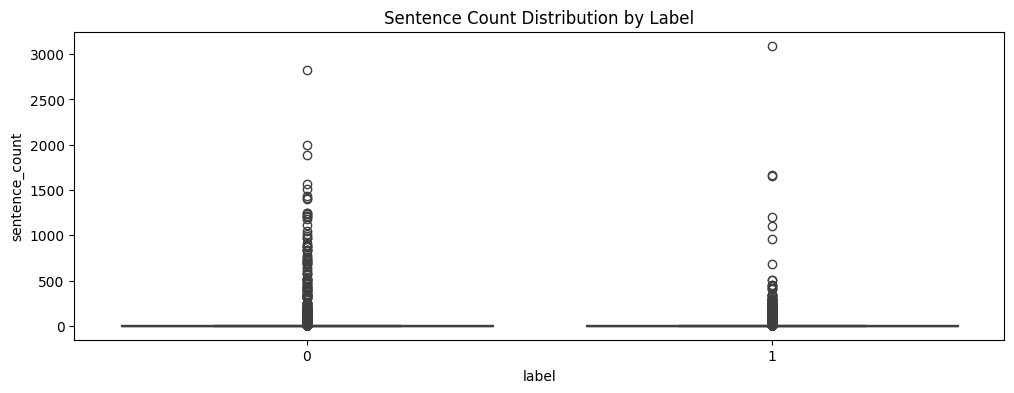

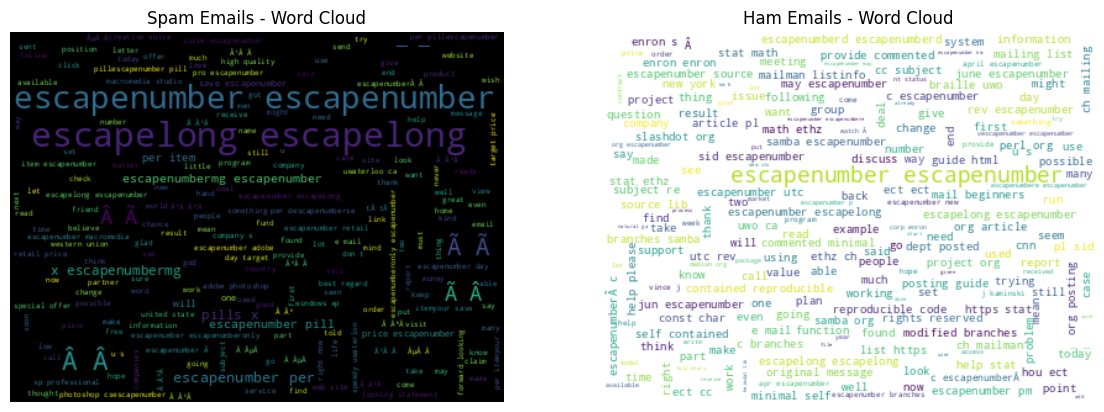

In [4]:


# --- Basic Info ---
print("Dataset Info:")
print(data.info())

# --- Check Missing Values and Duplicates ---
print("Missing values per column:\n", data.isnull().sum())
print("Number of duplicate rows:", data.duplicated().sum())
data = data.drop_duplicates().reset_index(drop=True)
print("Shape after removing duplicates:", data.shape)

# --- Label Distribution ---
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=data)
plt.title("Distribution of Spam vs. Ham")
plt.xlabel("Label (0 = Ham, 1 = Spam)")
plt.show()

# # --- Text Feature Engineering ---
# data['text_length'] = data['text'].apply(len)
# data['word_count'] = data['text'].apply(lambda x: len(word_tokenize(str(x))))  # Fix: Ensure text is converted to string
# data['sentence_count'] = data['text'].apply(lambda x: len(sent_tokenize(str(x))))  # Fix: Ensure text is converted to string
# --- Text Feature Engineering ---
data['text_length'] = data['text'].apply(len)
data['word_count'] = data['text'].apply(lambda x: len(word_tokenize(x)))
data['sentence_count'] = data['text'].apply(lambda x: len(sent_tokenize(x)))
print("Average text length:", data['text_length'].mean())
print("Average word count:", data['word_count'].mean())
print("Average sentence count:", data['sentence_count'].mean())

# --- Visualizations ---
plt.figure(figsize=(12,4))
sns.boxplot(x='label', y='text_length', data=data)
plt.title("Text Length Distribution by Label")
plt.show()

plt.figure(figsize=(12,4))
sns.boxplot(x='label', y='word_count', data=data)
plt.title("Word Count Distribution by Label")
plt.show()

plt.figure(figsize=(12,4))
sns.boxplot(x='label', y='sentence_count', data=data)
plt.title("Sentence Count Distribution by Label")
plt.show()

# --- Generate Word Clouds for Spam and Ham ---
spam_text = " ".join(data[data['label'] == 1]['text'].astype(str))  # Fix: Convert text column to string
ham_text = " ".join(data[data['label'] == 0]['text'].astype(str))

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
wordcloud_spam = WordCloud(width=400, height=300, background_color='black').generate(spam_text)
plt.imshow(wordcloud_spam, interpolation="bilinear")
plt.title("Spam Emails - Word Cloud")
plt.axis("off")

plt.subplot(1,2,2)
wordcloud_ham = WordCloud(width=400, height=300, background_color='white').generate(ham_text)
plt.imshow(wordcloud_ham, interpolation="bilinear")
plt.title("Ham Emails - Word Cloud")
plt.axis("off")
plt.show()


# Data Cleaning and Preprocessing

In [5]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove non-alphabetic characters (punctuation, numbers, etc.)
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

# Apply preprocessing
data['clean_text'] = data['text'].apply(preprocess_text)
print("Sample of original vs. cleaned text:")
data[['text', 'clean_text']].head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


Sample of original vs. cleaned text:


,text,clean_text
0,ounce feather bowl hummingbird opec moment ala...,ounce feather bowl hummingbird opec moment ala...
1,wulvob get your medircations online qnb ikud v...,wulvob get medircations online qnb ikud viagra...
2,computer connection from cnn com wednesday es...,computer connection cnn com wednesday escapenu...
3,university degree obtain a prosperous future m...,university degree obtain prosperous future mon...
4,thanks for all your answers guys i know i shou...,thanks answer guy know checked rsync manual wo...


# Feature Extraction with TF-IDF

In [8]:
# Apply preprocessing
# Data Preprocessing - Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(data['clean_text'])
y = data['label']



# Train-Test Split

In [10]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (66758, 5000)
Testing set shape: (16690, 5000)


# Model Training and Evaluation

In [9]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

def train_and_evaluate(model, model_name):
    """Train the model and evaluate its performance."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')  # Weighted for class imbalance
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n{model_name} Accuracy: {accuracy:.4f}")
    print(f"{model_name} Precision: {precision:.4f}")
    print(f"{model_name} Confusion Matrix:\n{cm}")

# Support Vector Classifier (SVC)
svc = SVC(kernel='linear')
train_and_evaluate(svc, "Support Vector Classifier (SVC)")

# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
train_and_evaluate(rf, "Random Forest Classifier")

# Naive Bayes Classifier
nb = MultinomialNB()
train_and_evaluate(nb, "Multinomial Naive Bayes")

# Logistic Regression
lr = LogisticRegression()
train_and_evaluate(lr, "Logistic Regression")


Training set shape: (66758, 5000)
Testing set shape: (16690, 5000)

Support Vector Classifier (SVC) Accuracy: 0.9851
Support Vector Classifier (SVC) Precision: 0.9851
Support Vector Classifier (SVC) Confusion Matrix:
[[7774  164]
 [  85 8667]]

Random Forest Classifier Accuracy: 0.9859
Random Forest Classifier Precision: 0.9859
Random Forest Classifier Confusion Matrix:
[[7809  129]
 [ 107 8645]]

Multinomial Naive Bayes Accuracy: 0.9648
Multinomial Naive Bayes Precision: 0.9650
Multinomial Naive Bayes Confusion Matrix:
[[7720  218]
 [ 369 8383]]

Logistic Regression Accuracy: 0.9824
Logistic Regression Precision: 0.9824
Logistic Regression Confusion Matrix:
[[7746  192]
 [ 102 8650]]
